In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles,Heatmap, LayersControl
from random import uniform
pd.set_option('float_format', '{:f}'.format)

In [2]:
cd ..

/Users/alphonsowoodbury/DS/Projects/aw_flatiron_group_projects/Module3_Project


In [3]:
df = pd.read_csv('data/cleaned_water_EDA.csv',index_col=0)

df_b = df.copy()
df_b['status_group'] = df_b['status_group'].replace(to_replace =["functional needs repair", "non functional"],value ="needs repair")
df.amount_tsh = df.amount_tsh.astype('int64')
df_b.amount_tsh = df_b.amount_tsh.astype('int64')

---

## Target

Status Group

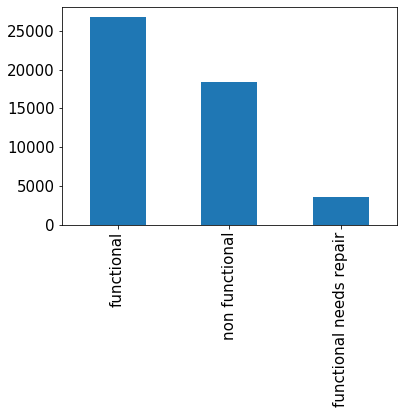

In [4]:
df.status_group.value_counts().plot(kind='bar',fontsize=15) #can this be a boxplot? #this is unbalanced

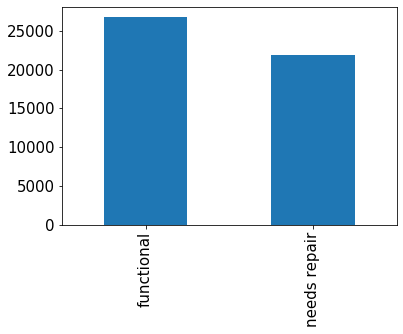

In [5]:
df_b.status_group.value_counts().plot(kind='bar',fontsize=15) #can this be a boxplot? #this is unbalanced

# Outliers: geographic?

- We identified a cluster of waterpoint observations with latitude and longitude that mapped them outside of Tanzania; these observations have the same age of 23 years and one coordinate (effectively 0,0)
- These observations will be obtained for modeling but cannot be included in any potential geographic plots .

In [6]:
df_g = df_b[df_b['longitude'] < 27.5]

In [7]:
df_g.longitude.value_counts()

0.000000    1326
Name: longitude, dtype: int64

In [8]:
df_g.latitude.value_counts()

-0.000000    1326
Name: latitude, dtype: int64

In [9]:
df_g.status_group.value_counts()

needs repair    740
functional      586
Name: status_group, dtype: int64

In [10]:
df_g.basin.value_counts()

Lake Victoria      1227
Lake Tanganyika      99
Name: basin, dtype: int64

In [11]:
#df_g.district_code.value_counts()

In [12]:
df_g.region.value_counts()

Shinyanga    696
Mwanza       630
Name: region, dtype: int64

In [13]:
df_g.payment_type.value_counts()

never pay     856
unknown       152
other         146
monthly        66
on failure     58
per bucket     32
annually       16
Name: payment_type, dtype: int64

In [14]:
df_g.age.value_counts() #they were constructed the same year!

23    1326
Name: age, dtype: int64

In [15]:
df_l = df_b[df_b['basin']== 'Lake Victoria']
df_l

,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,lga,...,permit,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,age
53,needs repair,0,Government Of Tanzania,0,Government,0.000000,-0.000000,Lake Victoria,Mwanza,Geita,...,True,submersible,vwc,unknown,unknown,dry,machine dbh,groundwater,communal standpipe multiple,23
59,needs repair,0,Government Of Tanzania,0,DWE,31.454282,-1.563886,Lake Victoria,Kagera,Bukoba Rural,...,True,handpump,vwc,never pay,soft,enough,shallow well,groundwater,hand pump,23
67,needs repair,0,Government Of Tanzania,0,DWE,30.716090,-1.285780,Lake Victoria,Kagera,Karagwe,...,True,gravity,vwc,never pay,soft,dry,spring,groundwater,other,23
85,needs repair,0,Swedish,0,Sengerema Water Department,32.185517,-2.378772,Lake Victoria,Mwanza,Sengerema,...,True,handpump,vwc,never pay,soft,seasonal,shallow well,groundwater,hand pump,23
94,needs repair,0,Hesawa,0,DWE,31.453111,-1.194390,Lake Victoria,Kagera,Misenyi,...,True,handpump,vwc,never pay,milky,insufficient,shallow well,groundwater,hand pump,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59371,needs repair,0,Netherlands,0,DWE,33.586406,-3.040369,Lake Victoria,Shinyanga,Maswa,...,False,handpump,wug,never pay,soft,enough,shallow well,groundwater,hand pump,23
59374,functional,0,Rwssp,0,DWE,0.000000,-0.000000,Lake Victoria,Shinyanga,Bariadi,...,False,handpump,wug,other,soft,enough,shallow well,groundwater,hand pump,23
59379,functional,0,Do,0,DO,31.613284,-1.820226,Lake Victoria,Kagera,Muleba,...,True,gravity,vwc,never pay,soft,enough,spring,groundwater,communal standpipe,23
59384,needs repair,0,Concern,0,CONCERN,30.667805,-2.483710,Lake Victoria,Kagera,Ngara,...,False,gravity,vwc,never pay,soft,insufficient,spring,groundwater,communal standpipe,23


---

## Features

### Water

- A LOT of 0 values, impute?

#### Feature: Tsh Value

In [16]:
df.amount_tsh.value_counts(bins=10)

(-250.001, 25000.0]     48614
(25000.0, 50000.0]         21
(100000.0, 125000.0]        7
(75000.0, 100000.0]         3
(50000.0, 75000.0]          2
(225000.0, 250000.0]        1
(175000.0, 200000.0]        1
(150000.0, 175000.0]        1
(125000.0, 150000.0]        1
(200000.0, 225000.0]        0
Name: amount_tsh, dtype: int64

In [17]:
(df.amount_tsh == 0).sum() #this is a bad feature

32516

In [18]:
# tshbins = range(0, df.amount_tsh.max(), 20000)
# df['tsh_bins'] = pd.cut(df.amount_tsh, bins=tshbins)
# tshs = pd.crosstab(df.tsh_bins,df.status_group,normalize='index')
# tshs.plot(kind='bar',figsize=(10,7.50),fontsize=10)
# tshs

status_group,functional,needs repair
tsh_bins,,
"(2, 25002]",0.699975,0.300025
"(25002, 50002]",0.857143,0.142857
"(50002, 75002]",0.500000,0.500000
"(75002, 100002]",0.666667,0.333333
"(100002, 125002]",0.857143,0.142857
"(125002, 150002]",1.000000,0.000000
"(150002, 175002]",1.000000,0.000000
"(175002, 200002]",1.000000,0.000000


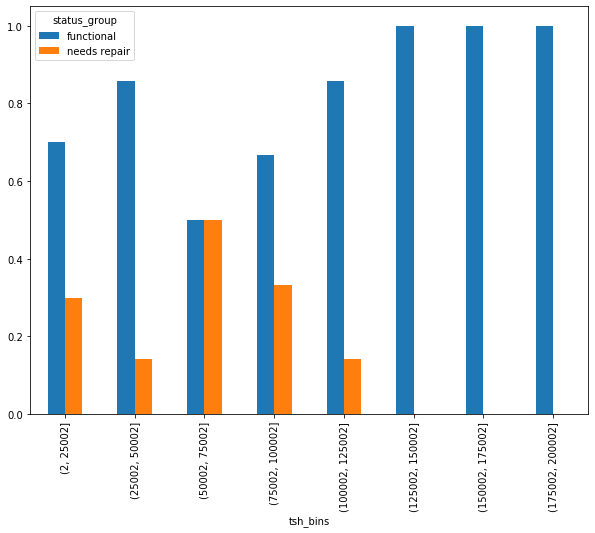

In [19]:
tshbinsb = range(2, df_b.amount_tsh.max(), 25000)
df_b['tsh_bins'] = pd.cut(df_b.amount_tsh, bins=tshbinsb)
tshsb = pd.crosstab(df_b.tsh_bins,df_b.status_group,normalize='index')
tshsb.plot(kind='bar',figsize=(10,7.50),fontsize=10)
tshsb

#### Feature: Quality

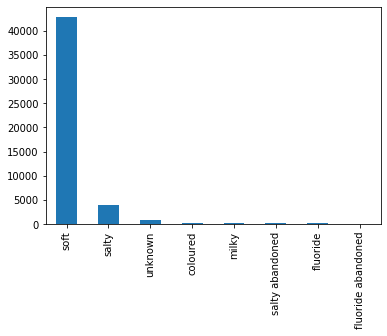

In [20]:
df.water_quality.value_counts().plot(kind='bar')

In [21]:
# watq = pd.crosstab(df.water_quality,df.status_group,normalize='index')
# watq.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
# watq.sort_values('functional',ascending=False)

status_group,functional,needs repair
water_quality,,
fluoride,0.775000,0.225000
soft,0.568008,0.431992
milky,0.565217,0.434783
coloured,0.509375,0.490625
salty abandoned,0.456897,0.543103
salty,0.443343,0.556657
fluoride abandoned,0.307692,0.692308
unknown,0.104545,0.895455


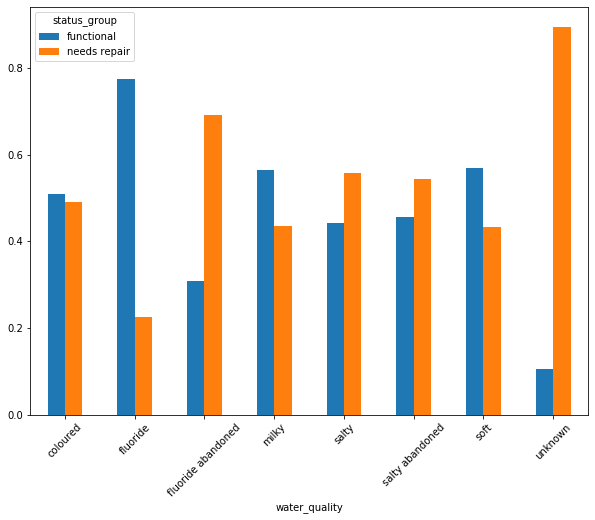

In [22]:
watqb = pd.crosstab(df_b.water_quality,df_b.status_group,normalize='index')
watqb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
plt.savefig('images/water_status.png')
watqb.sort_values('functional',ascending=False)

In [23]:
qualities = df.water_quality.value_counts().index.tolist()

In [24]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].population.mean()
    print(qual+':' + str(mean))

soft:167.933241456635
salty:271.2799796747967
unknown:151.8181818181818
coloured:152.034375
milky:127.07357859531773
salty abandoned:95.78448275862068
fluoride:193.7375
fluoride abandoned:118.3076923076923


In [25]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].age.mean()
    print(qual+':' + str(mean))

soft:23.184204994043586
salty:22.984756097560975
unknown:24.41590909090909
coloured:22.90625
milky:23.67558528428094
salty abandoned:23.198275862068964
fluoride:19.475
fluoride abandoned:20.615384615384617


In [26]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].permit.mean()
    print('permit+'+qual+':' + str(mean))

permit+soft:0.7030202518044428
permit+salty:0.5251524390243902
permit+unknown:0.5659090909090909
permit+coloured:0.765625
permit+milky:0.6722408026755853
permit+salty abandoned:0.23706896551724138
permit+fluoride:0.90625
permit+fluoride abandoned:0.23076923076923078


In [27]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].public_meeting.mean()
    print('public_meeting+'+qual+':' + str(mean))

public_meeting+soft:0.9143911611501717
public_meeting+salty:0.881859756097561
public_meeting+unknown:0.8875
public_meeting+coloured:0.84375
public_meeting+milky:0.8595317725752508
public_meeting+salty abandoned:0.8836206896551724
public_meeting+fluoride:1.0
public_meeting+fluoride abandoned:1.0


#### Feature: Quantity

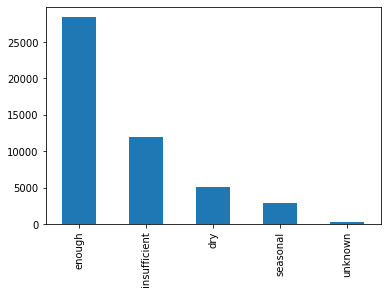

In [28]:
df.quantity.value_counts().plot(kind='bar')

In [29]:
# quant = pd.crosstab(df.quantity,df.status_group,normalize='index')
# quant.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
# quant.sort_values('functional',ascending=False)

status_group,functional,needs repair
quantity,,
enough,0.655901,0.344099
seasonal,0.569263,0.430737
insufficient,0.522561,0.477439
unknown,0.206897,0.793103
dry,0.024687,0.975313


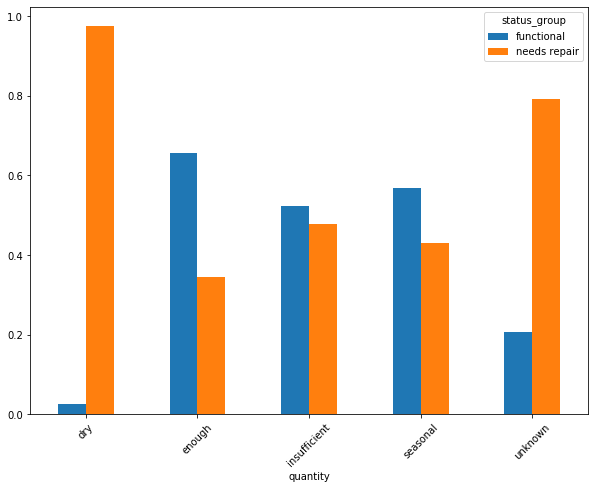

In [30]:
quantb = pd.crosstab(df_b.quantity,df_b.status_group,normalize='index')
quantb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
quantb.sort_values('functional',ascending=False)

#### Feature: Source

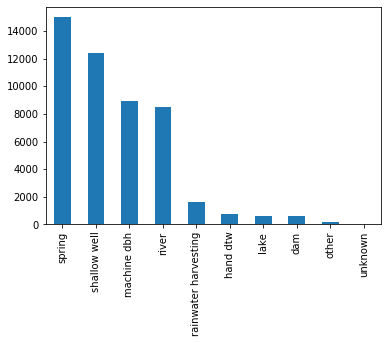

In [31]:
df.source.value_counts().plot(kind='bar')

In [32]:
# src = pd.crosstab(df.source,df.status_group,normalize='index',margins=True,margins_name='Status of all Sources')
# src.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
# src.sort_values('functional',ascending=False)

status_group,functional,needs repair
source,,
other,0.670330,0.329670
spring,0.625742,0.374258
river,0.584529,0.415471
rainwater harvesting,0.581829,0.418171
hand dtw,0.562259,0.437741
Status of all Sources,0.549218,0.450782
shallow well,0.500443,0.499557
machine dbh,0.478280,0.521720
unknown,0.468750,0.531250


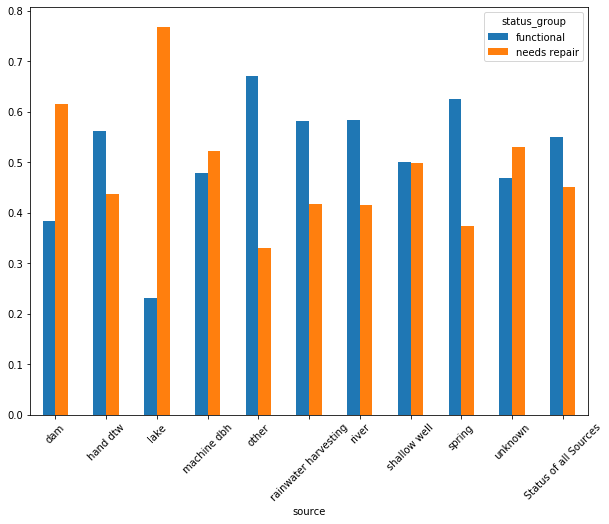

In [33]:
srcb = pd.crosstab(df_b.source,df_b.status_group,normalize='index',margins=True,margins_name='Status of all Sources')
srcb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
srcb.sort_values('functional',ascending=False)

#### Source Class

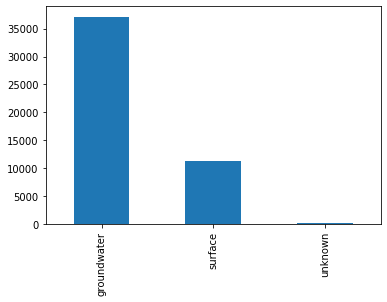

In [34]:
df.source_class.value_counts().plot(kind='bar')

In [35]:
# srcc = pd.crosstab(df.source_class,df.status_group,margins=True,normalize='index')#
# srcc.plot(kind='bar',figsize=(10,7.5),rot=45)
# srcc.sort_values('functional',ascending=False)

status_group,functional,needs repair
source_class,,
unknown,0.640187,0.359813
surface,0.554916,0.445084
All,0.549218,0.450782
groundwater,0.546960,0.453040


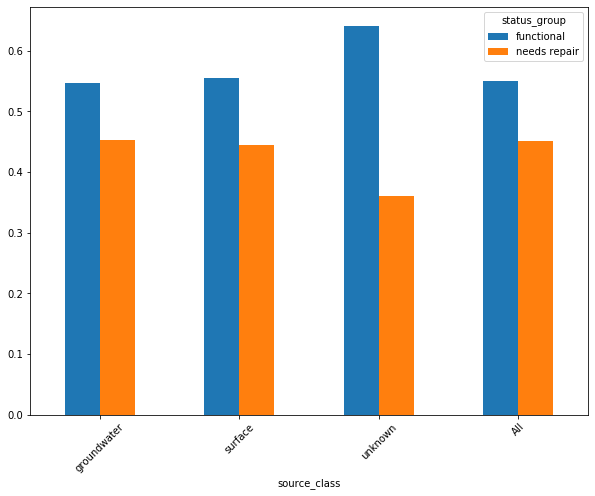

In [36]:
srccb = pd.crosstab(df_b.source_class,df_b.status_group,margins=True,normalize='index')#
srccb.plot(kind='bar',figsize=(10,7.5),rot=45)
srccb.sort_values('functional',ascending=False)

#### Feature: Basin

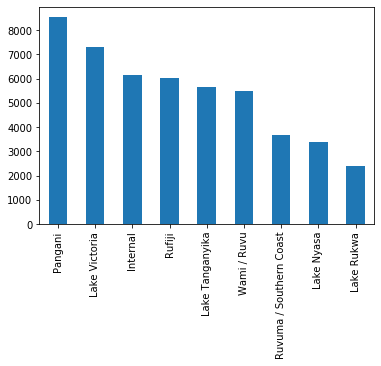

In [37]:
df.basin.value_counts().plot(kind='bar')

status_group,functional,needs repair
basin,,
Lake Nyasa,0.692239,0.307761
Rufiji,0.668380,0.331620
Pangani,0.602927,0.397073
Internal,0.601625,0.398375
All,0.549218,0.450782
Wami / Ruvu,0.510386,0.489614
Lake Victoria,0.493102,0.506898
Lake Tanganyika,0.477132,0.522868
Lake Rukwa,0.411324,0.588676


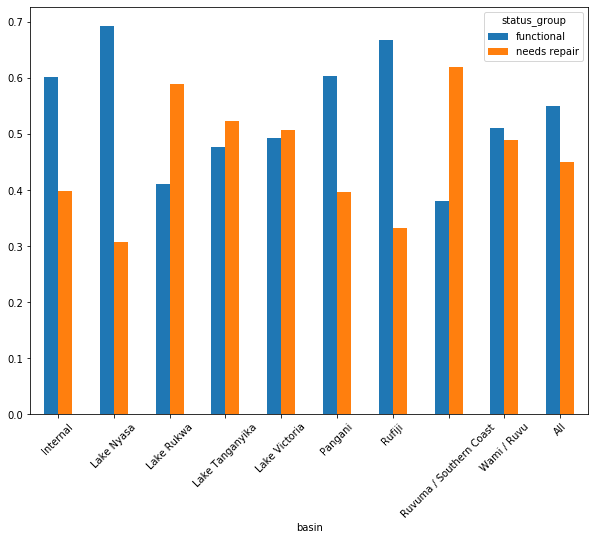

In [38]:
basin = pd.crosstab([df_b.basin],df_b.status_group,margins=True,normalize='index')#
basin.plot(kind='bar',figsize=(10,7.5),rot=45)
basin.sort_values('functional',ascending=False)

do they have different water?

### Waterpoint

#### Feature: Waterpoint Age

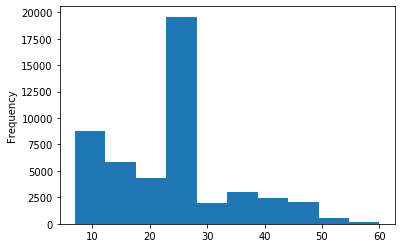

In [39]:
df.age.plot(kind='hist') #knn? 

In [40]:
agebins = range(0, df.age.max(), 10)
df['age_bucket'] = pd.cut(df.age, bins=agebins)

In [41]:
# ages = pd.crosstab(df.age_bucket,df.status_group,normalize='index')
# ages.plot(kind='bar',figsize=(10,7.5),title='title',rot=45)
# ages

###### **Binary**

In [42]:
mybins = range(0, df_b.age.max(), 10)
df_b['age_bucket'] = pd.cut(df_b.age, bins=mybins)

status_group,functional,needs repair
age_bucket,,
"(0, 10]",0.733616,0.266384
"(10, 20]",0.661978,0.338022
"(20, 30]",0.519066,0.480934
"(30, 40]",0.421561,0.578439
"(40, 50]",0.335172,0.664828


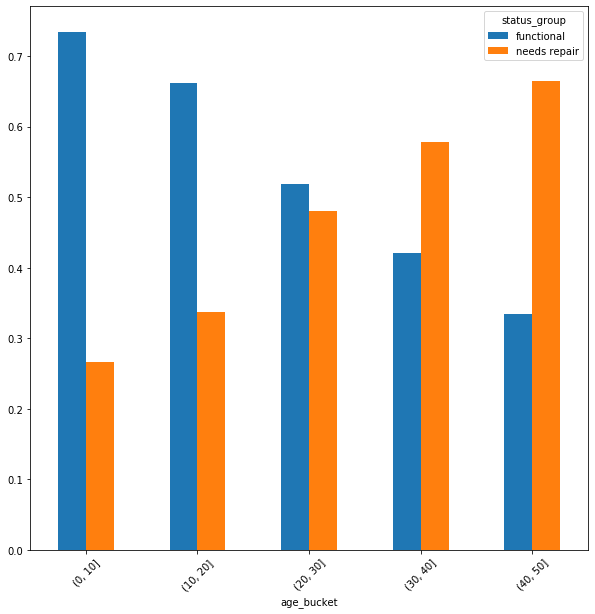

In [43]:
ages_b = pd.crosstab(df_b.age_bucket,df_b.status_group,normalize='index')
ages_b.plot(kind='bar',figsize=(10,10),rot=45)
plt.savefig('images/age_status.png')
ages_b

did the technology change?

df_age_gt_25 = df_b[df_b['age'] > 25]

status_group,functional,needs repair
waterpoint_type,,
dam,1.000000,0.000000
cattle trough,0.736842,0.263158
improved spring,0.611111,0.388889
communal standpipe,0.532859,0.467141
hand pump,0.530100,0.469900
communal standpipe multiple,0.194476,0.805524
other,0.060462,0.939538


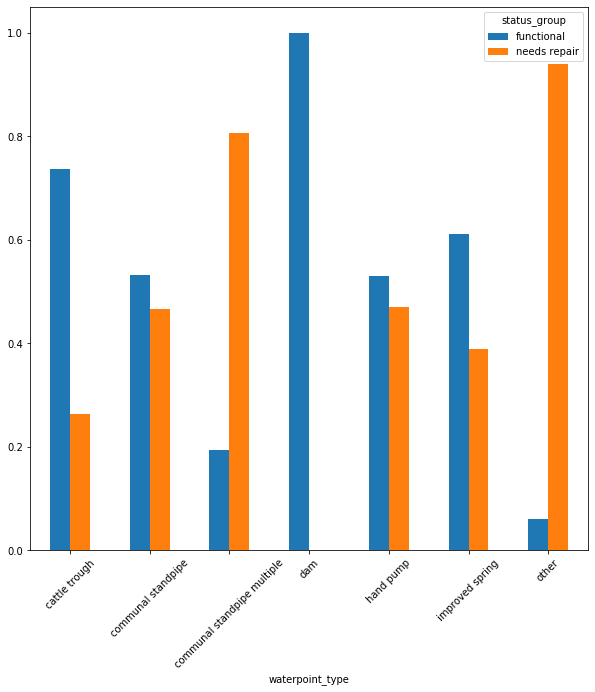

In [45]:
ages_g25 = pd.crosstab(df_age_gt_25.waterpoint_type,df_age_gt_25.status_group,normalize='index')
ages_g25.plot(kind='bar',figsize=(10,10),rot=45)
plt.savefig('images/ageg25_status.png')
ages_g25.sort_values('functional',ascending=False)

In [46]:
df_age_lt_25 = df_b[df_b['age'] < 25]

status_group,functional,needs repair
waterpoint_type,,
dam,1.000000,0.000000
cattle trough,0.761905,0.238095
improved spring,0.731993,0.268007
communal standpipe,0.666569,0.333431
hand pump,0.629457,0.370543
communal standpipe multiple,0.439037,0.560963
other,0.159341,0.840659


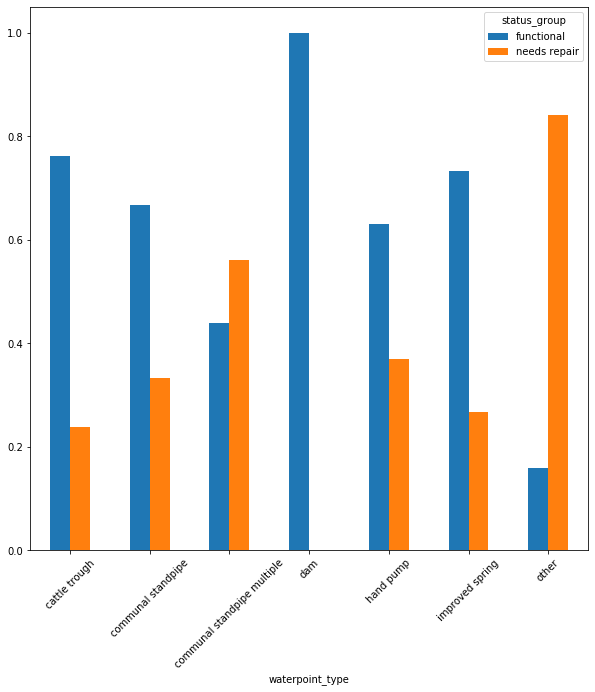

In [47]:
ages_l25 = pd.crosstab(df_age_lt_25.waterpoint_type,df_age_lt_25.status_group,normalize='index')
ages_l25.plot(kind='bar',figsize=(10,10),rot=45)
plt.savefig('images/ageg25_status.png')
ages_l25.sort_values('functional',ascending=False)

#### Feature: Waterpoint Type

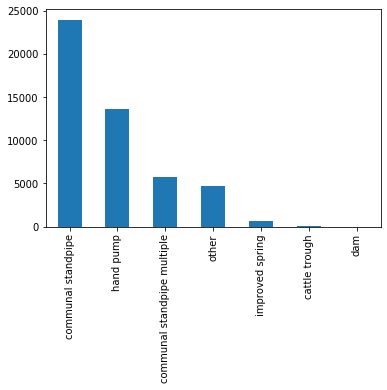

In [48]:
df.waterpoint_type.value_counts().plot(kind='bar')

In [49]:
# wpttp = pd.crosstab(df.waterpoint_type,df.status_group,normalize='index')
# wpttp.plot(kind='bar',figsize=(10,7.5),rot=45)
# wpttp.sort_values('functional',ascending=False)

###### **Binary**

status_group,functional,needs repair
waterpoint_type,,
dam,1.000000,0.000000
cattle trough,0.756098,0.243902
improved spring,0.721966,0.278034
communal standpipe,0.631221,0.368779
hand pump,0.616306,0.383694
communal standpipe multiple,0.370156,0.629844
other,0.122234,0.877766


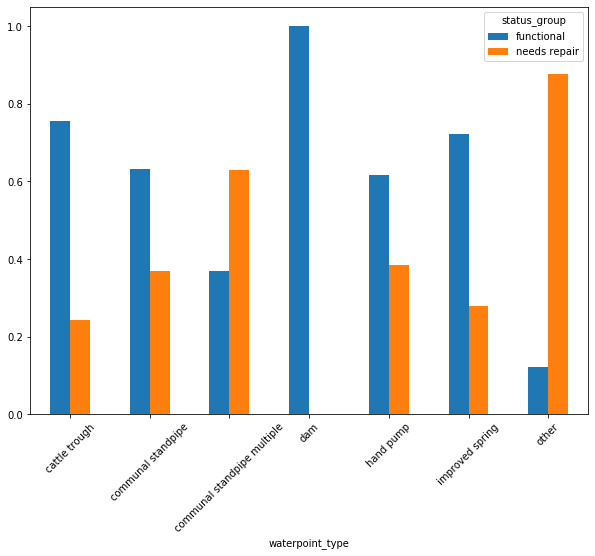

In [50]:
wpttpb = pd.crosstab(df_b.waterpoint_type,df_b.status_group,normalize='index')
wpttpb.plot(kind='bar',figsize=(10,7.5),rot=45)
wpttpb.sort_values('functional',ascending=False)

#### Extraction Type

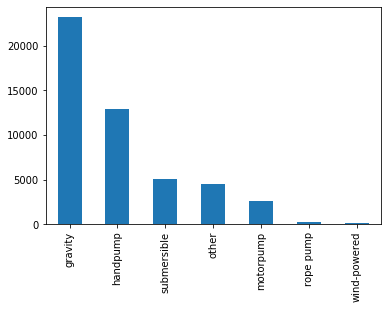

In [51]:
df.extraction_type_class.value_counts().plot(kind='bar')

In [52]:
# exttp = pd.crosstab(df.extraction_type_class,df.status_group,normalize='index')
# exttp.plot(kind='bar',figsize=(10,7.5),rot=45)
# exttp.sort_values('functional',ascending=False)

###### **Binary**

status_group,functional,needs repair
extraction_type_class,,
rope pump,0.636792,0.363208
handpump,0.629644,0.370356
gravity,0.609020,0.390980
submersible,0.521346,0.478654
wind-powered,0.413462,0.586538
motorpump,0.394275,0.605725
other,0.134963,0.865037


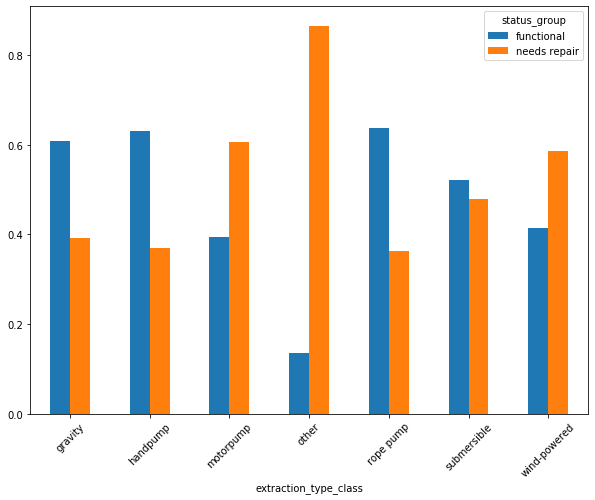

In [53]:
exttpb = pd.crosstab(df_b.extraction_type_class,df_b.status_group,normalize='index')
exttpb.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.savefig('images/extract_status.png')
exttpb.sort_values('functional',ascending=False)

### Governance

#### Feature: Permit

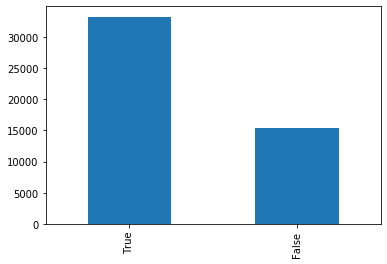

In [54]:
df.permit.value_counts().plot(kind='bar')

In [55]:
# permit = pd.crosstab(df.permit,df.status_group,normalize='index')
# permit.plot(kind='bar',figsize=(10,7.5),rot=45)
# permit.sort_values('functional',ascending=False)

status_group,functional,needs repair
permit,,
True,0.568521,0.431479
False,0.507301,0.492699


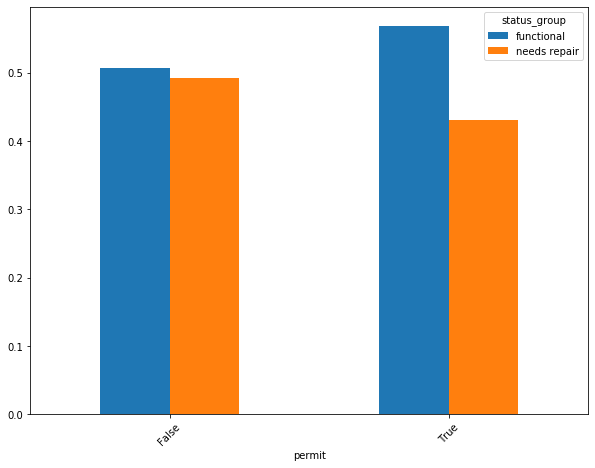

In [56]:
permitb = pd.crosstab(df_b.permit,df_b.status_group,normalize='index')
permitb.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.savefig('images/permit_status.png')
permitb.sort_values('functional',ascending=False)

#### Feature: Public Meeting

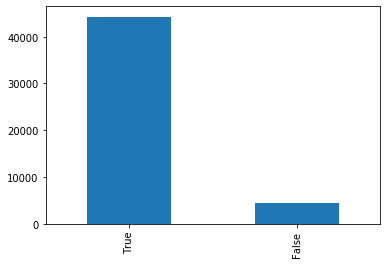

In [57]:
df.public_meeting.value_counts().plot(kind='bar')

In [58]:
# meet = pd.crosstab(df.public_meeting,df.status_group,normalize='index')
# meet.plot(kind='bar',figsize=(10,7.5),rot=45)
# meet.sort_values('functional',ascending=False)

status_group,functional,needs repair
public_meeting,,
True,0.562784,0.437216
False,0.410994,0.589006


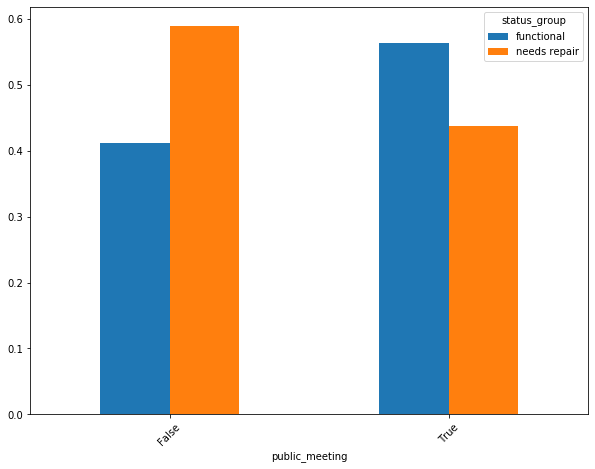

In [59]:
meetb = pd.crosstab(df_b.public_meeting,df_b.status_group,normalize='index')
meetb.plot(kind='bar',figsize=(10,7.5),rot=45)
meetb.sort_values('functional',ascending=False)

#### Feature: Mangagement

#### Feature: Funder

gpsheaight; a mountain? outlier?
longitude, are there errors? shouldnt be so far from the rest
construction year issues


In [60]:
top10funders = df['funder'].value_counts().index.tolist()[:11]
top10funders

['Government Of Tanzania',
 'Danida',
 'Hesawa',
 'Kkkt',
 'World Bank',
 'World Vision',
 'Unicef',
 'Rwssp',
 'District Council',
 'Tasaf',
 'Private Individual']

status_group,functional,needs repair
funder,,
Private Individual,0.843546,0.156454
Rwssp,0.593516,0.406484
World Vision,0.589080,0.410920
Unicef,0.589055,0.410945
Danida,0.570890,0.429110
Tasaf,0.559085,0.440915
Kkkt,0.559080,0.440920
District Council,0.456929,0.543071
Hesawa,0.448524,0.551476


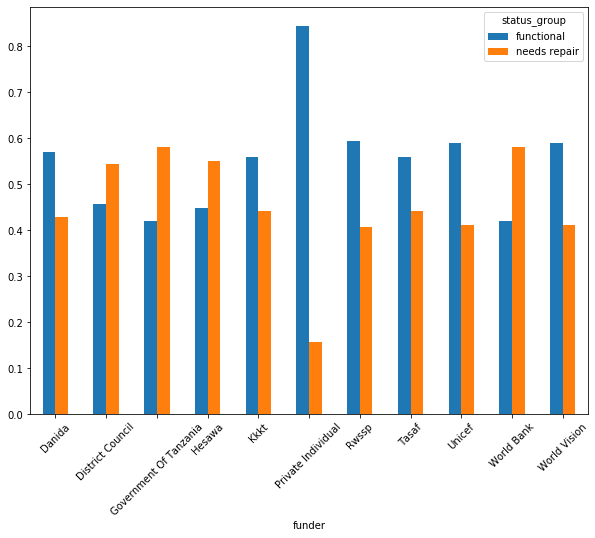

In [61]:
df_f = df_b[df_b['funder'].isin(top10funders)]
funders = pd.crosstab(df_f.funder,df_f.status_group,normalize='index')
funders.plot(kind='bar',figsize=(10,7.5),rot=45)
funders.sort_values('functional',ascending=False)

In [62]:
priv = df_b[df_b['funder'] == 'Private Individual']

In [63]:
priv.age.value_counts(bins=10) ##most privately funded waterpoints were built in the last 20 years

(7.947, 13.2]    390
(13.2, 18.4]     227
(18.4, 23.6]     114
(28.8, 34.0]       9
(44.4, 49.6]       8
(34.0, 39.2]       8
(23.6, 28.8]       7
(54.8, 60.0]       2
(39.2, 44.4]       2
(49.6, 54.8]       0
Name: age, dtype: int64

In [64]:
priv.extraction_type_class.value_counts()

submersible     439
gravity         192
motorpump        48
handpump         47
other            34
wind-powered      4
rope pump         3
Name: extraction_type_class, dtype: int64

In [65]:
df_b.extraction_type_class.value_counts()

gravity         23170
handpump        12920
submersible      5083
other            4542
motorpump        2620
rope pump         212
wind-powered      104
Name: extraction_type_class, dtype: int64

#### Feature: Installer

In [66]:
df.installer.value_counts()

DWE                    14670
Government              1438
Commu                   1059
RWE                     1032
KKKT                     885
                       ...  
SINGIDA  YETU              1
Mwananchi Engineeri        1
Rusumo Game reserve        1
Ongan                      1
Morovian Church            1
Name: installer, Length: 1799, dtype: int64

In [67]:
top10installers = df.installer.value_counts().index.tolist()[:11]
top10installers

['DWE',
 'Government',
 'Commu',
 'RWE',
 'KKKT',
 'DANIDA',
 'TCRS',
 'Central government',
 'CES',
 'Hesawa',
 'DANID']

status_group,functional,needs repair
installer,,
CES,0.881967,0.118033
DANID,0.780797,0.219203
Commu,0.682720,0.317280
Hesawa,0.617857,0.382143
DANIDA,0.580720,0.419280
DWE,0.550511,0.449489
KKKT,0.466667,0.533333
TCRS,0.399701,0.600299
Government,0.276773,0.723227


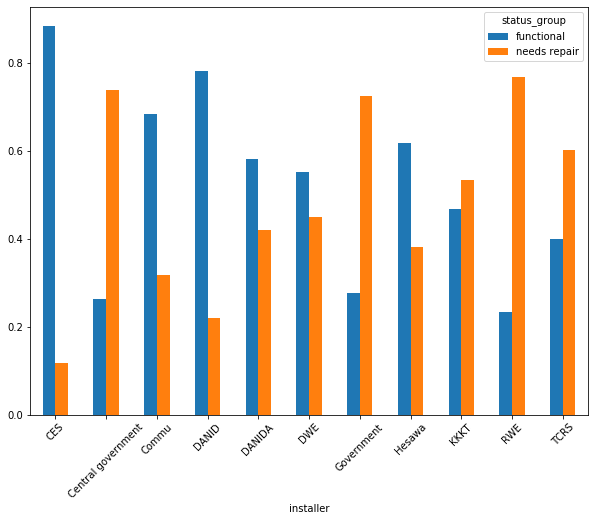

In [68]:
df_i = df_b[df_b['installer'].isin(top10installers)]
installers = pd.crosstab([df_i.installer],df_i.status_group,normalize='index')
installers.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.savefig('images/allinstallers_status.png')
installers.sort_values('functional',ascending=False)

status_group,functional,needs repair
installer,,
ACRA,0.978339,0.021661
Magadini-Makiwaru wa,0.977143,0.022857
Dmdd,0.964789,0.035211
Co,0.945455,0.054545
St,0.944444,0.055556
Oikos E .Africa,0.937500,0.062500
Lawatefuka water sup,0.933333,0.066667
DAWASCO,0.921875,0.078125
Losaa-Kia water supp,0.919355,0.080645


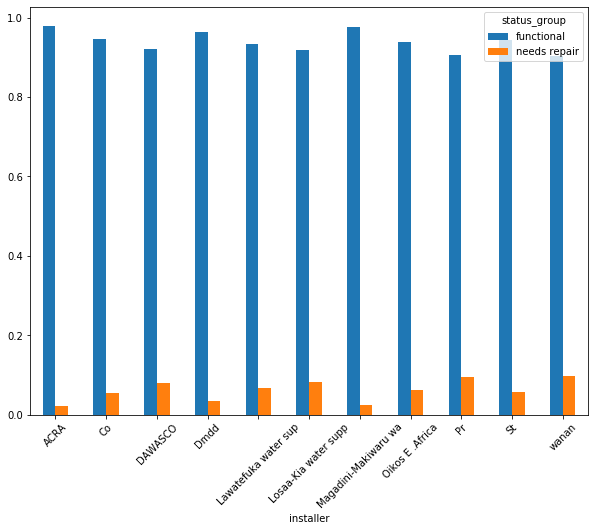

In [69]:
top100installers = df.installer.value_counts().index.tolist()[:135]
df_i2 = df_b[df_b['installer'].isin(top100installers)]
installers100 = pd.crosstab([df_i2.installer],df_i2.status_group,normalize='index')
installers100 = installers100[installers100['functional'] > 0.90]
installers100.plot(kind='bar',figsize=(10,7.5),rot=45)
plt.savefig('images/topinstallers_status.png')
installers100.sort_values('functional',ascending=False)

In [70]:
installers90club = installers100.index.tolist()
inst90clb = df_b[df_b['installer'].isin(installers90club)]

In [71]:
inst90clb.installer.value_counts()

Dmdd                    284
ACRA                    277
Lawatefuka water sup    180
Magadini-Makiwaru wa    175
Oikos E .Africa          80
DAWASCO                  64
Losaa-Kia water supp     62
Co                       55
St                       54
Pr                       53
wanan                    52
Name: installer, dtype: int64

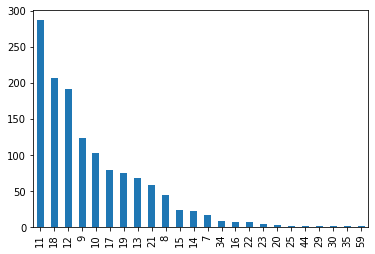

In [72]:
inst90clb.age.value_counts().plot(kind='bar')

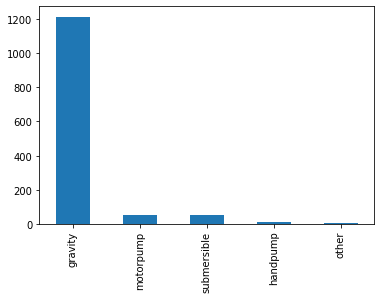

In [73]:
inst90clb.extraction_type_class.value_counts().plot(kind='bar')

(<matplotlib.axes._subplots.AxesSubplot at 0x1a27901828>,)

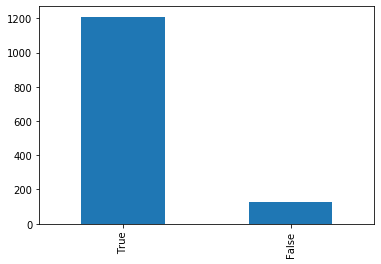

In [74]:
inst90clb.permit.value_counts().plot(kind='bar'),

(<matplotlib.axes._subplots.AxesSubplot at 0x1a295b58d0>,)

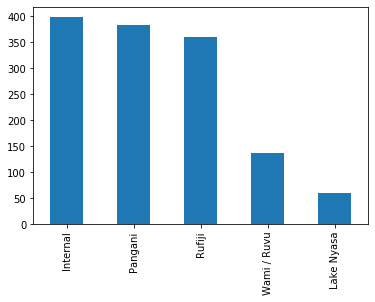

In [75]:
inst90clb.basin.value_counts().plot(kind='bar'),

(<matplotlib.axes._subplots.AxesSubplot at 0x1a25988278>,)

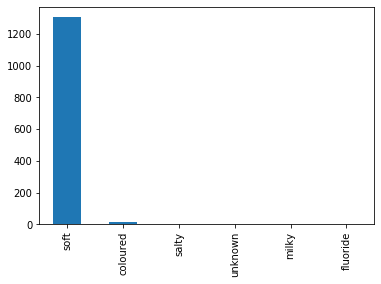

In [76]:
inst90clb.water_quality.value_counts().plot(kind='bar'), #NOTE: the most effective installers may be most effective because of the water quality

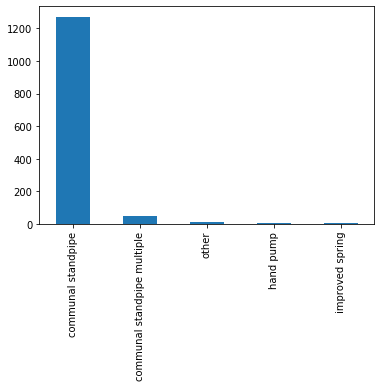

In [77]:
inst90clb.waterpoint_type.value_counts().plot(kind='bar')

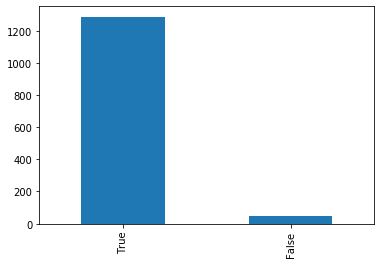

In [78]:
inst90clb.public_meeting.value_counts().plot(kind='bar')

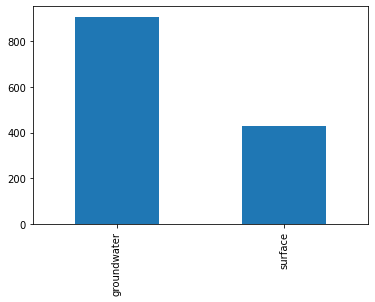

In [79]:
inst90clb.source_class.value_counts().plot(kind='bar')

In [80]:
inst90clb.population.mean()

135.23877245508982

Analysis: waterpoints with **soft water**,**groundwater or surface**, **permitted**,at a **communal standpipe** functioning with **gravity** are 90% operational when installed by the inst90clb

status_group,functional,needs repair
installer,,
District council,0.240933,0.759067
RWE,0.233527,0.766473
GOVER,0.232000,0.768000
DA,0.226190,0.773810
Finwater,0.206897,0.793103
Halmashauri ya wilaya sikonge,0.204082,0.795918
Adra/Community,0.200000,0.800000
Water board,0.185185,0.814815
FinW,0.182692,0.817308


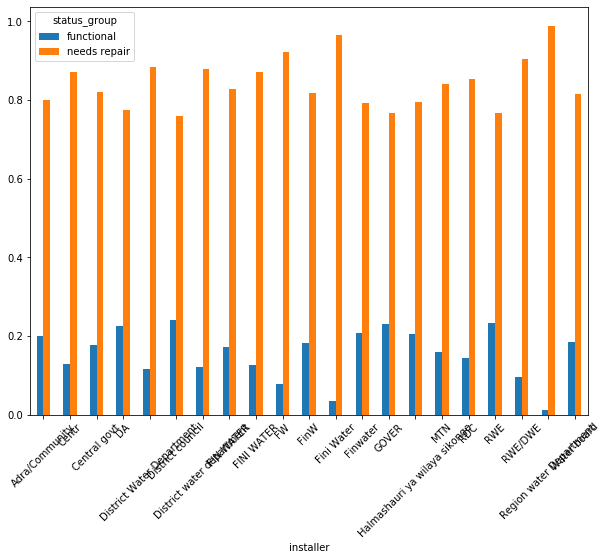

In [81]:
atleast50 = df.installer.value_counts().index.tolist()[:135]
df_i3 = df_b[df_b['installer'].isin(atleast50)]
bottominst = pd.crosstab([df_i3.installer],df_i2.status_group,normalize='index')
bottominst = bottominst[bottominst['functional'] < 0.25]
bottominst.plot(kind='bar',figsize=(10,7.5),rot=45)
bottominst.sort_values('functional',ascending=False)

In [82]:
installers25club = bottominst.index.tolist()
inst25clb = df_b[df_b['installer'].isin(installers25club)]

In [83]:
inst25clb.age.mean()

33.76490577695397

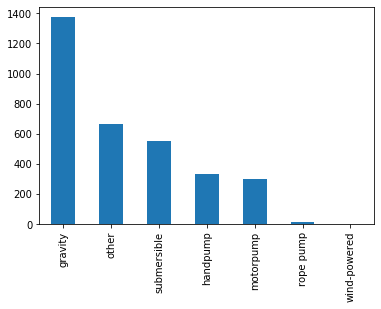

In [84]:
inst25clb.extraction_type_class.value_counts().plot(kind='bar')

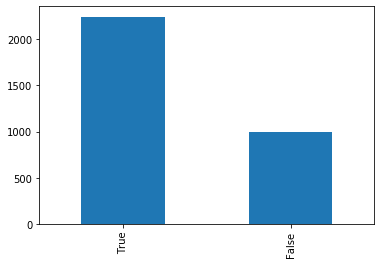

In [85]:
inst25clb.permit.value_counts().plot(kind='bar')

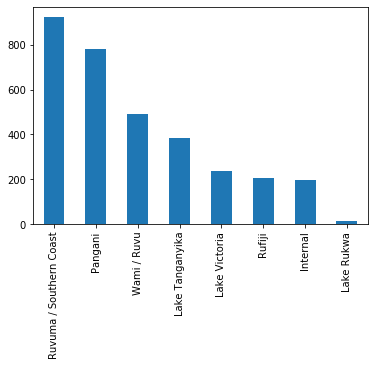

In [86]:
inst25clb.basin.value_counts().plot(kind='bar')

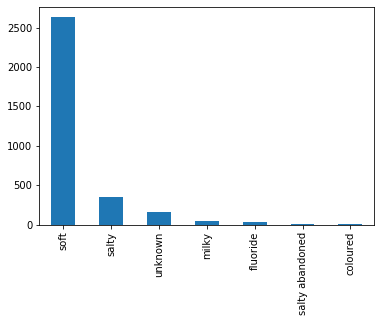

In [87]:
inst25clb.water_quality.value_counts().plot(kind='bar')

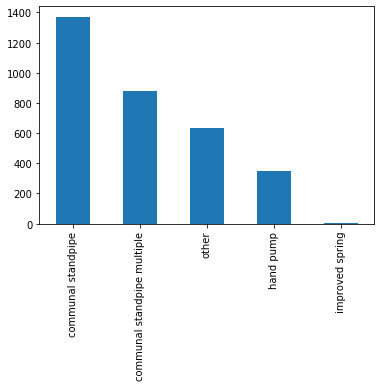

In [88]:
inst25clb.waterpoint_type.value_counts().plot(kind='bar')

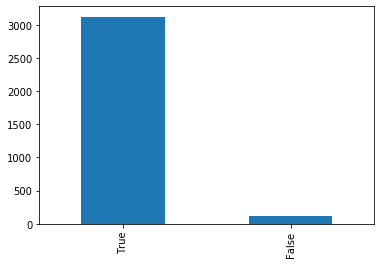

In [89]:
inst25clb.public_meeting.value_counts().plot(kind='bar')

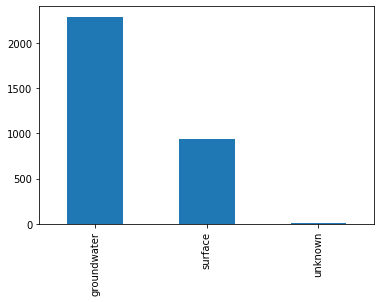

In [90]:
inst25clb.source_class.value_counts().plot(kind='bar')

In [95]:
inst25clb.value_counts().plot(kind='bar')

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [ ]:
inst25clb.population.mean()#.plot(kind='bar')

In [ ]:
inst25clb.public_meeting.value_counts().plot(kind='bar')